In [1]:
import pandas as pd
from fbprophet import Prophet
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('tnf_5year.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262 entries, Week to 2020-07-12
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Category: All categories  262 non-null    object
dtypes: object(1)
memory usage: 4.1+ KB


In [4]:
#Checking the format of the dataframe
#We have weekley data

df.head()

,Category: All categories
Week,The north face: (Worldwide)
2015-07-19,21
2015-07-26,23
2015-08-02,21
2015-08-09,23


In [5]:
#Remove the first row of data

df = df.drop(df.index[0])

In [6]:
#Rename the columns as per FB Prophet requirements

df['ds'] = df.index


In [7]:
#Reset the index

df = df.reset_index(drop=True)

#Rename 
df = df.rename(columns={"Category: All categories": "y"})

#Order the colums

df = df[['ds', 'y']]

#ds column to datetime

df['ds'] = pd.to_datetime(df['ds'])

df.head()


,ds,y
0,2015-07-19,21
1,2015-07-26,23
2,2015-08-02,21
3,2015-08-09,23
4,2015-08-16,24


In [8]:
#Change the data type of the y column

df['y'] = df['y'].astype(float)

In [9]:
df.head()

,ds,y
0,2015-07-19,21.0
1,2015-07-26,23.0
2,2015-08-02,21.0
3,2015-08-09,23.0
4,2015-08-16,24.0


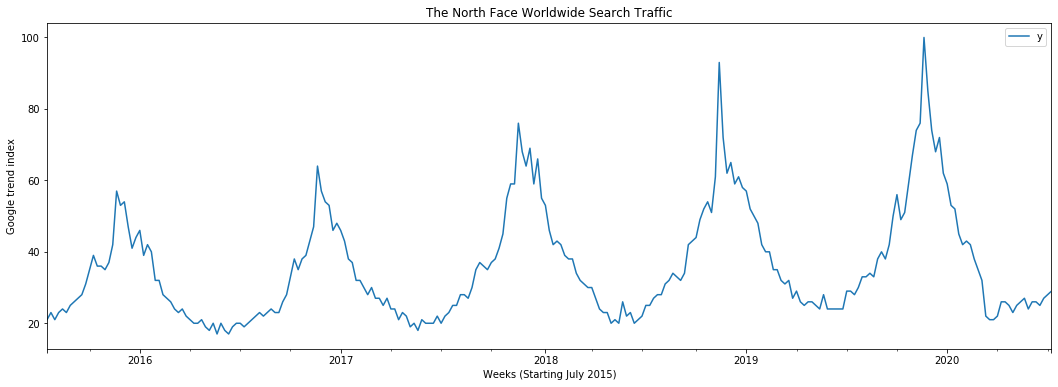

In [10]:
#Plot the data

ax = df.plot(x='ds',y='y',figsize=(18,6))

ax.set_xlabel("Weeks (Starting July 2015)")
ax.set_ylabel("Google trend index")
ax.set_title("The North Face Worldwide Search Traffic")

plt.savefig('search_volumes.jpeg')

The brand experience it largest volume of search traffic in the late autumn. This will be driven by the core market looking for equipment for the winter season and the consumer market buying product for Christmas. Summer sees the lowest volume of search traffic.

Seasonality is consistent, there is an upward trend and the peaks and data is increasing in proportion. 

Due to covid the drop off in traffic at the start of 2020 has been more extreme than would have otherwise been expected with volumes dropping to summer 2018 levels. 

The summer 2020 trough looks like it has extended further than usual and making a recent recovery. 

It is important to note from a modelling perspective that the data is multiplicative - the search traffic is growing at an increasing rate. 

In real terms this means that the brand is growing at an exponential rate, however the spring of 2020 may have changed this. 

## Train test split

In [11]:
len(df)

261

In [12]:
#We will be forecasting 1 year into the future (52 weeks)

len(df)-52

209

In [13]:
train = df.iloc[:209]
test = df.iloc[209:]

## Build the forecasting model

In [14]:
#Set to weekly data and forecast 52 periods.

m = Prophet(seasonality_mode='multiplicative')
m.fit(train)
future = m.make_future_dataframe(periods=52,freq='W')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Compare the forecast with the test

In [15]:
#yhat is the value we are interested in

forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
256,2020-06-14,42.513278,20.855215,28.334908,41.620205,43.299590,-0.418002,-0.418002,-0.418002,-0.418002,-0.418002,-0.418002,0.0,0.0,0.0,24.742658
257,2020-06-21,42.552905,21.350474,28.623030,41.637230,43.373487,-0.409816,-0.409816,-0.409816,-0.409816,-0.409816,-0.409816,0.0,0.0,0.0,25.114041
258,2020-06-28,42.592531,22.356968,29.658415,41.655409,43.440433,-0.387832,-0.387832,-0.387832,-0.387832,-0.387832,-0.387832,0.0,0.0,0.0,26.073803
259,2020-07-05,42.632157,23.540725,30.774551,41.673306,43.502333,-0.361354,-0.361354,-0.361354,-0.361354,-0.361354,-0.361354,0.0,0.0,0.0,27.226842
260,2020-07-12,42.671784,24.605344,32.117341,41.677253,43.563976,-0.331490,-0.331490,-0.331490,-0.331490,-0.331490,-0.331490,0.0,0.0,0.0,28.526496


In [16]:
test.tail()

,ds,y
256,2020-06-14,26.0
257,2020-06-21,25.0
258,2020-06-28,27.0
259,2020-07-05,28.0
260,2020-07-12,29.0


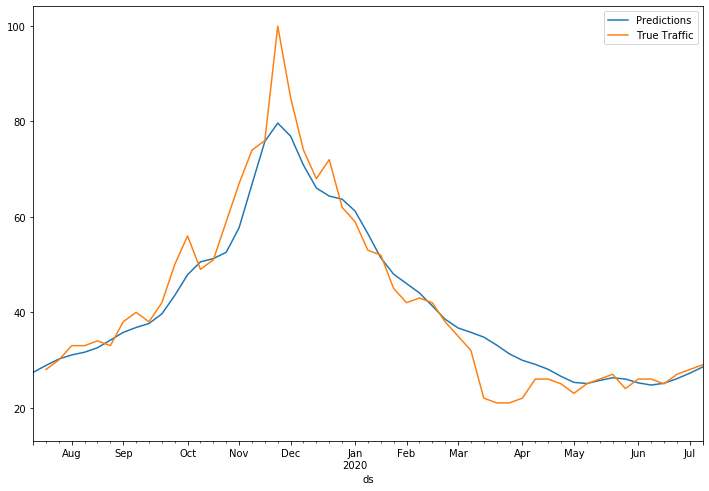

In [17]:
#Plot the forecast vs the test

ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

test.plot(x='ds',y='y',label='True Traffic',legend=True, ax=ax,xlim=('2019-07-12','2020-07-12'))

plt.savefig('forecast_test.jpeg')

The predictions show a good representation of the true results just with a smoother curve.

## Evaluation of model performance

In [18]:
#Using RMSE 

from statsmodels.tools.eval_measures import rmse

In [19]:
#Extract the predicted values

predictions = forecast.iloc[-52:]['yhat']

In [20]:
predictions

209    28.854029
210    30.195411
211    31.055004
212    31.626522
213    32.568366
214    34.150159
215    35.785344
216    36.807684
217    37.641706
218    39.662799
219    43.516978
220    47.876792
221    50.569433
222    51.262406
223    52.572319
224    57.731300
225    66.840829
226    75.823186
227    79.664924
228    76.913218
229    70.831354
230    66.063572
231    64.363079
232    63.705720
233    61.238145
234    56.481071
235    51.426940
236    47.984434
237    46.023013
238    44.063105
239    41.330262
240    38.541313
241    36.716090
242    35.789651
243    34.784372
244    33.121459
245    31.261955
246    29.928244
247    29.078824
248    28.040384
249    26.561240
250    25.302197
251    25.057296
252    25.706179
253    26.267490
254    26.002239
255    25.199295
256    24.742658
257    25.114041
258    26.073803
259    27.226842
260    28.526496
Name: yhat, dtype: float64

In [21]:
test['y']

209     28.0
210     30.0
211     33.0
212     33.0
213     34.0
214     33.0
215     38.0
216     40.0
217     38.0
218     42.0
219     50.0
220     56.0
221     49.0
222     51.0
223     59.0
224     67.0
225     74.0
226     76.0
227    100.0
228     85.0
229     74.0
230     68.0
231     72.0
232     62.0
233     59.0
234     53.0
235     52.0
236     45.0
237     42.0
238     43.0
239     42.0
240     38.0
241     35.0
242     32.0
243     22.0
244     21.0
245     21.0
246     22.0
247     26.0
248     26.0
249     25.0
250     23.0
251     25.0
252     26.0
253     27.0
254     24.0
255     26.0
256     26.0
257     25.0
258     27.0
259     28.0
260     29.0
Name: y, dtype: float64

In [22]:
rmse(predictions,test['y'])

5.2690609297226985

In [23]:
test.mean()

y    41.961538
dtype: float64

In [24]:
rmse(predictions,test['y']) / test.mean()

y    0.125569
dtype: float64

12% away from the mean, not a bad performance. 

## Retraining the model on the whole dataset 

In [25]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(periods=52,freq='W')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


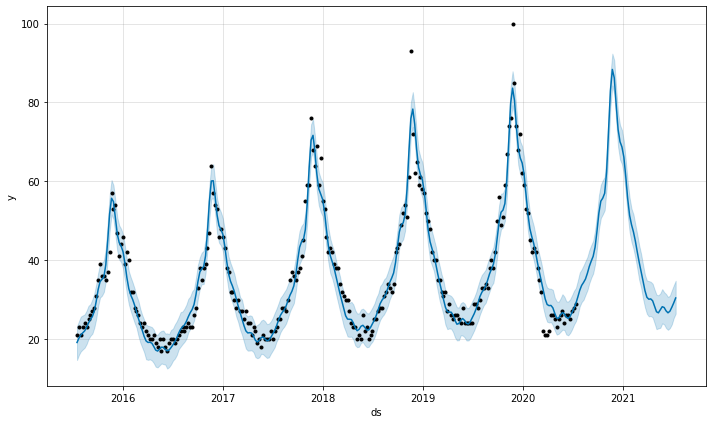

In [26]:
m.plot(forecast);

plt.savefig('full_dataset_plot.jpeg')

Forecast shows a continuation in the seasonality of the search traffic for the brand and a continuation of the positive trend but a slower rate. 

## Changes in the trends

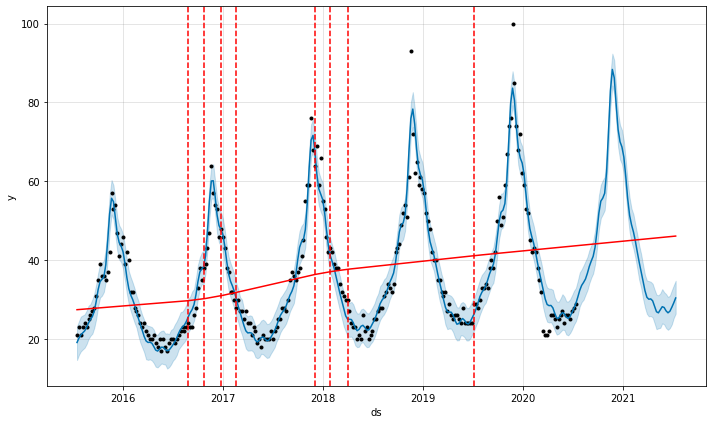

In [27]:
#Adding change points to the graph.

from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),m,forecast)


From the summer of 2019 the trend has been postitive but not at the rate it had been previously. 

Autumn 2016 through to the start of 2018 was the brand's high growth period. 

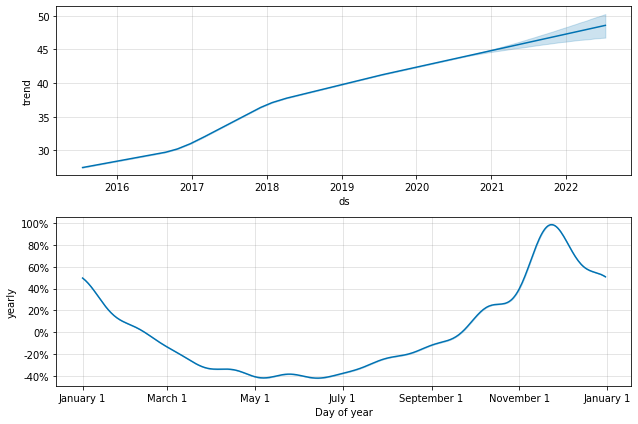

In [38]:
#Plotting the trend components

fig = m.plot_components(forecast)

plt.savefig('components.jpeg')

Clear picture of the trend being postive at a decreasing rate and the winter being the peak season. 

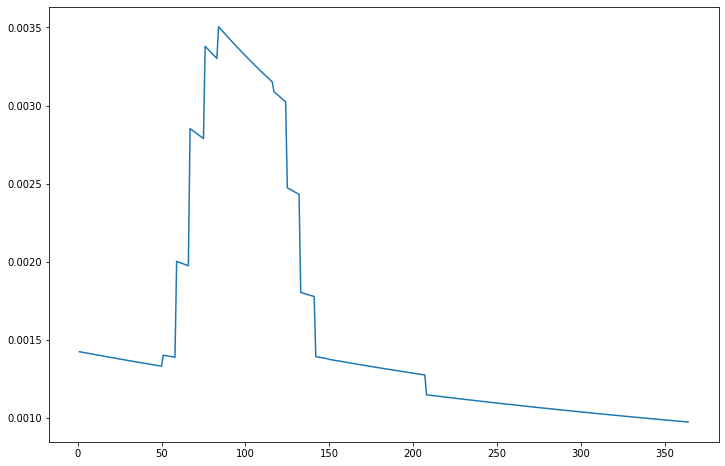

In [37]:
#Evaluate the percentage change of 'trend'

forecast['trend'].pct_change().plot(figsize=(12,8))

plt.savefig('first_difference.jpeg')

We can see that the brand had high growth in search traffic from the summer of 2016 and since then the rate has been decreasing. 

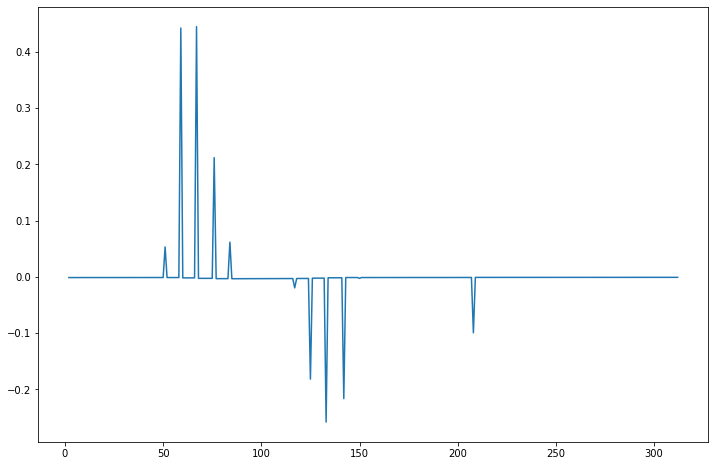

In [30]:
#Taking the second differential - the rate of the rate.

rate_1 = forecast['trend'].pct_change()

rate_1.pct_change().plot(figsize=(12,8))

This shows an incresing rate of rate of growth folled by a decreasing rate of rate of growth. 

## Forecasting two periods ahead

In [31]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(periods=104,freq='W')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


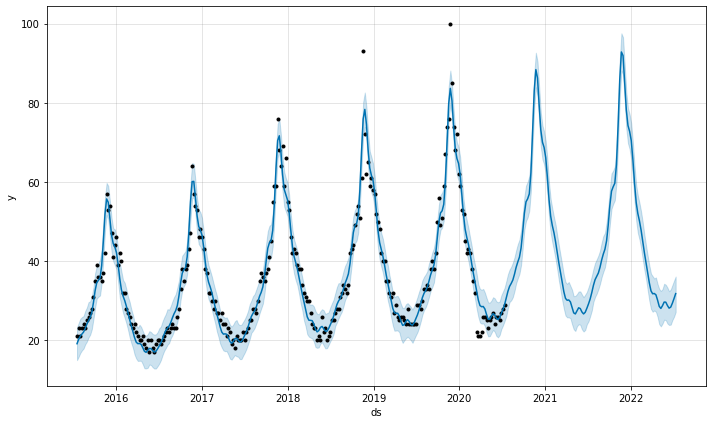

In [32]:
m.plot(forecast);

Forecast shows a continuation in the seasonality of the search traffic for the brand and a continuation of the positive trend but a slower rate. 

## Changes in the trends

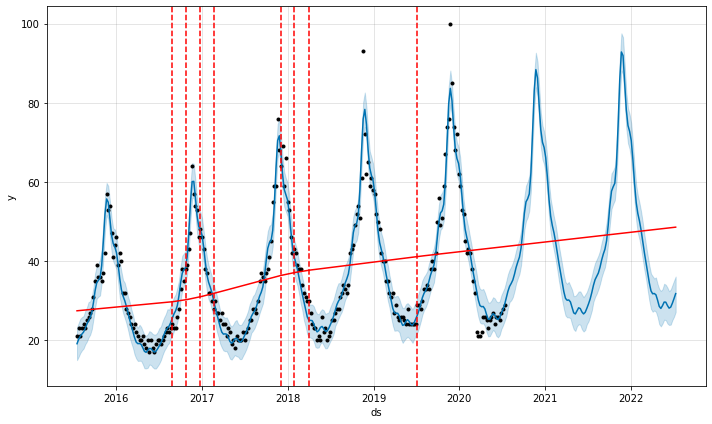

In [33]:
#Adding change points to the graph.

from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),m,forecast)

From the summer of 2019 the trend has been postitive but not at the rate it had been previously. 

Autumn 2016 through to the start of 2018 was the brand's high growth period. 

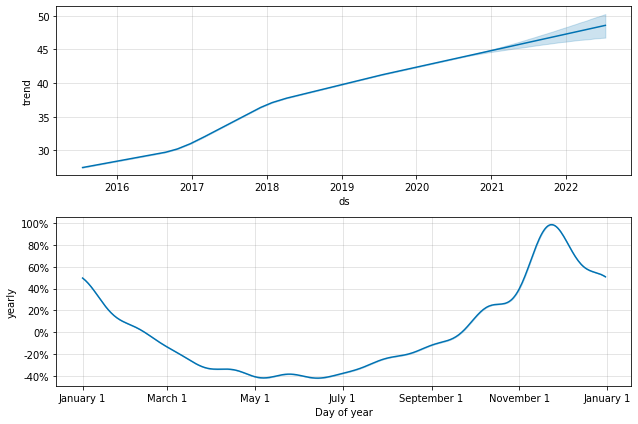

In [34]:
#Plotting the trend components

fig = m.plot_components(forecast)

Clear picture of the trend being postive at a decreasing rate and the winter being the peak season. 

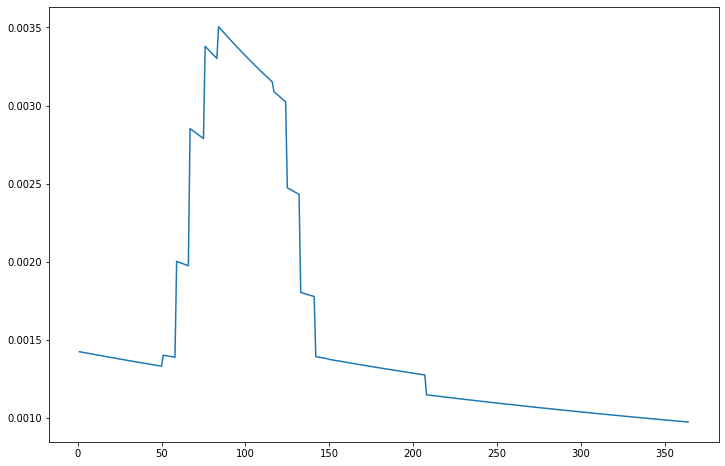

In [35]:
#Evaluate the percentage change of 'trend'

forecast['trend'].pct_change().plot(figsize=(12,8))

We can see that the brand had high growth in search traffic from the summer of 2016 and since then the rate has been decreasing. 

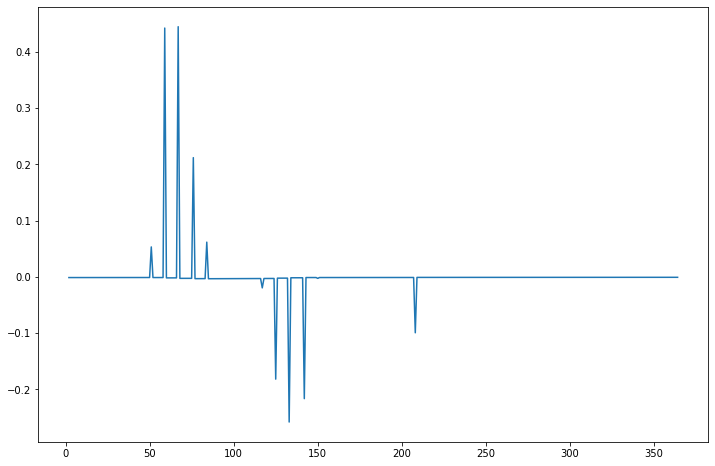

In [36]:
#Taking the second differential - the rate of the rate.

rate_1 = forecast['trend'].pct_change()

rate_1.pct_change().plot(figsize=(12,8))

This shows an incresing rate of rate of growth folled by a decreasing rate of rate of growth. 